In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import csv
import time
import sys
import random

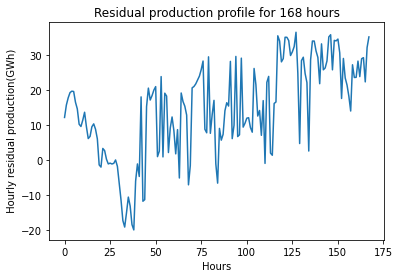

In [3]:
# On fixe le nombre d'heures étudiées pour réduire la taille du problème
h = 168 #une semaine

#Hourly electricity production in 2016 (reference year)
resultats_2016 = pd.read_csv("Données/hourly profiles with demand of 2016.csv")
resultats_2016 = resultats_2016.to_numpy()

vre = pd.read_csv("Données/vre_profiles2006.csv")
vre = vre.to_numpy()

offshore = np.zeros((8760,2))
offshore[:,1] = resultats_2016[:,1]*vre[0:8760,2]
offshore[:,0] = resultats_2016[:,0]

onshore = np.zeros((8760,2))
onshore[:,1] = resultats_2016[:,2]*vre[8760:17520,2]
onshore[:,0] = resultats_2016[:,0]

PV = np.zeros((8760,2))
PV[:,1] = resultats_2016[:,3]*vre[17520:26280,2]
PV[:,0] = resultats_2016[:,0]

river = np.zeros((8760,2))
river[:,1] = resultats_2016[:,4] #*vre[26280:35040,2]
river[:,0] = resultats_2016[:,0]

lake = np.zeros((8760,2))
lake[:,1] = resultats_2016[:,5] #*vre[35040:43800,2]
lake[:,0] = resultats_2016[:,0]

biogas = np.zeros((8760,2))
biogas[:,1] = resultats_2016[:,6] #*vre[43800:52560,2]
biogas[:,0] = resultats_2016[:,0]

gas = np.zeros((8760,2))
gas[:,1] = resultats_2016[:,7] #*vre[52560:61320,2]
gas[:,0] = resultats_2016[:,0]

prodf = np.zeros((8760,2))
prodf[:,0] = resultats_2016[:,0]
prodf[:,1] = offshore[:,1] + onshore[:,1]+ PV[:,1] + river[:,1] + lake[:,1] + biogas[:,1] + gas[:,1] 

##Electricity demand in 2050 (Negawatt)
demande = pd.read_csv("Données/demand2050_negawatt.csv")  
demande = demande.to_numpy()

#Residual production
Production_res = np.zeros((8760,2))
Production_res[:,0] = np.copy(prodf[:,0])
Production_res[:,1] = prodf[:,1] - demande[:,1]
#Reduced problem
PR = np.zeros((h,2))
PR[:,0] = Production_res[0:h,0]
PR[:,1] = Production_res[0:h,1]

#Residual production profile
plt.plot(PR[:,1])
plt.title("Residual production profile for %d hours"%h)
plt.xlabel('Hours')
plt.ylabel(' Hourly residual production(GWh)')
plt.show()

In [4]:
#Cost /technology
a = 25.805  #phs
b = 87.9481 #methanation

#maximal stock
xmax = 180   #valeur pour l'année 2006 (page 34, table 1.2 appendix 3)
ymax = 7740 

#contrainte par rapport aux flux entrants et sortant
Rb = 50 #6.2
Db = 40 #7.2
Rm = 8
Dm = 15  ### valeurs ????
#Nous n'avons pas trouvé de valeurs concernant Rm, Dm

In [100]:
def proxC(U1,a,b,h): #prox de c (fonction coût)
    prox = np.zeros_like(U1)
    for k in range(h):
        
        #seuillage doux sur la première composante
        if U1[k] > a :
            prox[k] = U1[k]-a
        if U1[k] < -a :
            prox[k] = U1[k] + a
        else :
            prox[k] = 0
    
        #seuillage doux sur la deuxième composante
        if U1[k+h] > b :
            prox[k+h] = U1[k+h]-b
        if U1[k+h] < -b :
            prox[k+h] = U1[k+h] + b
        else :
            prox[k+h] = 0
    return prox


def proxP(U2, PR, h): #prox de p (projection sur la production résiduelle)
    #contrainte de production: (projection orthogonale)
    prox = np.copy(U2)
    for k in range(h):
        if U2[k]+U2[k+h] > PR[k]:
            prox[k] = (1/2)*(U2[k] + PR[k]-U2[k+h])
            prox[k+h] = PR[k] - (1/2)*(U2[k] + PR[k]-U2[k+h])
    return prox

def proxF(U3, Rb, Db, Rm, Dm, h): #prox de f (contrainte sur les flux)
    prox = np.copy(U3)
    #contrainte de flux: (boîte)
    
    prox[:h][np.where(prox[:h] > Rb)] = Rb
    prox[:h][np.where(prox[:h] < Db)] = Db
    
    prox[h:][np.where(prox[h:] > Rm)] = Rm
    prox[h:][np.where(prox[h:] < Dm)] = Dm
    
    return prox

def proxS(Ui,xmax,ymax,h): #en un vecteur, une des 8760 contraintes sur la somme cumulative (max de stocks)
    prox = np.copy(Ui)
    for i in range(h):
        xcum = sum(prox[:i])
        ycum = sum(prox[h:i])
        if xcum > xmax:
            diff = xcum - xmax
            h1 = diff/i
            prox[:i] -= h1*np.ones(np.shape(Ui[:i])[0])
        if ycum > ymax:
            diff2 = ycum - ymax
            h2 = diff2/i
            prox[h:i+h] -= h2*np.ones(np.shape(Ui[h:i+h])[0])
    return prox
    
def proxD(U): #prox de l'indicatrice d'égalité de toutes les variables (h+3)
    prox = np.zeros_like(U)
    N = np.shape(U)[0]
    for k in range(N):
        prox[k,:] = np.mean(U[k,:])*np.ones(np.shape(U)[1])
    return prox
        
def proxg(U,a,b,Rb, Db, Rm,Dm,PR,xmax,ymax,h): #rassemblement de tous les prox 
    Res = np.copy(U)
    N1,N2 = np.shape(Res)
    Res[:,0] = proxC(U[:,0],a,b,h)
    Res[:,1] = proxP(U[:,1],PR,h)
    Res[:,2] = proxF(U[:,2], Rb,Db,Rm,Dm,h)
    for i in range(3, N2):
        Res[:,i] = proxS(U[:,i], xmax, ymax, h)
    return Res
             
        

def DR(X0,a,b,Rb, Db, Rm,Dm,PR,xmax,ymax,h, eps = 1e-5,g=2, itermax = 150): #algo de douglas rachford
    k = 0
    X = np.copy(X0)
    while k<itermax: 
        k+=1
        Yk = g*proxg(X,a,b,Rb, Db, Rm,Dm,PR,xmax,ymax,h)
        Zk = g*proxD(2*Yk-X)
        X = X + (0.5)*(Zk-Yk)
        
    return X

In [67]:
X_0 = np.ones((2*h, h+3))
result = DR(X_0, a,b,Rb, Db, Rm,Dm, Production_res[:,1],xmax,ymax,h)

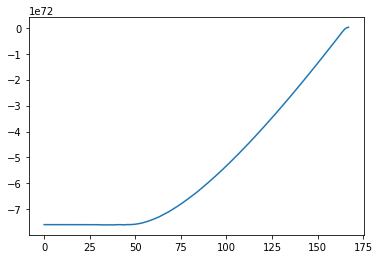

In [85]:
plt.plot(result[:h,0]) #flux barrages sur 168h

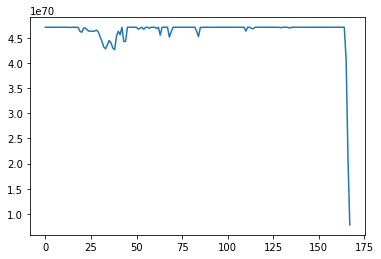

In [86]:
plt.plot(result[h:,0]) #méthanation

In [78]:
print(np.shape(result))

(336, 171)


In [49]:
## TEST DES PROX ##

Uc = np.ones(6)
Uc[0] = 5
Uc[1] = 10
Uc[2] = -4
Uc[3] = 6
Uc[4] = -10
Uc[5] = 18

print("Résultat attendu : (0,0,-2,0,-5,0)")
print(proxC(Uc,2,5,3))

Résultat attendu : (0,0,-2,0,-5,0)
[ 0.  0. -2.  0. -5.  0.]


In [91]:
Up = Uc
PRp = np.ones(3)
PRp[0] = 10
PRp[1] = 8
PRp[2] = 4


print("Résultat attendu : (4.5,10,-9,5.5,-10,13)")
print(proxP(Up,PRp,3))

Résultat attendu : (4.5,10,-9,5.5,-10,13)
[  4.5  10.   -9.    5.5 -10.   13. ]


In [92]:
print("Résultat attendu : (4.5, 4.5, -4, 4.5, -5, 4.5)")
print(proxF(Up, 4.5, -5, 4.5, -5, 3))

Résultat attendu : (4.5, 4.5, -4, 4.5, -5, 4.5)
[ 4.5  4.5 -4.   4.5 -5.   4.5]


In [103]:
print("Résultat attendu : (??)")
Up[0] = 20 #pour que des le depart ca depasse
print(proxS(Up, 14,6, 3))

Résultat attendu : (??)
[  9.   5.  -4.   6. -10.  18.]


In [65]:
Ud = np.ones((2,3))
Ud[0,0] = 5
Ud[1,0] = 6
Ud[0,1] = 10
Ud[1,1] = -10
Ud[0,2] = -4
Ud[1,2] = 18
print("Résultat attendu : (3.6, 4.6)")
print(proxD(Ud))

Résultat attendu : (3.6, 4.6)
[[3.66666667 3.66666667 3.66666667]
 [4.66666667 4.66666667 4.66666667]]


[5.]
